In [3]:
import os
import numpy as np
import cv2

# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMG_CHANNELS = 1  # For grayscale (binary masks)

# Function to load images and masks
def load_images(image_folder, mask_folder):
    images = []
    masks = []

    # List all files in both image and mask folders
    image_files = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if os.path.isfile(os.path.join(mask_folder, f)) and f.endswith('.png')])

    # Check if both folders have the same number of files
    if len(image_files) != len(mask_files):
        print(f"Number of images ({len(image_files)}) does not match number of masks ({len(mask_files)}).")
        return None, None

    # Debug: Check file names
    print(f"Image Files: {image_files}")
    print(f"Mask Files: {mask_files}")

    # Iterate through image and mask files
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        # Read and resize the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to read image {img_file}.")
            continue
        
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = np.expand_dims(img, axis=-1) / 255.0  # Normalize and reshape
        
        # Read and resize the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Failed to read mask {mask_file}.")
            continue
        
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = np.expand_dims(mask, axis=-1) / 255.0
        
        # Append image and mask to their respective lists
        images.append(img)
        masks.append(mask)

    print(f"Successfully loaded {len(images)} images and {len(masks)} masks.")
    return np.array(images), np.array(masks)

# Provide correct paths to your image and mask folders
image_folder = 'train/original_image'
mask_folder = 'train/binary_mask'

# Load images and masks
images, masks = load_images(image_folder, mask_folder)

if images is not None and masks is not None:
    print(f"Loaded {len(images)} images and {len(masks)} masks.")
else:
    print("Error loading images and masks.")


Image Files: ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define the UNet model
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Load and prepare data

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create and compile the UNet model
model = unet_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=10)

# Save the model
model.save('unet_model.h5')

print("Model training complete and saved.")


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.9540 - loss: 1.2051 - val_accuracy: 0.9829 - val_loss: 0.0690
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.9833 - loss: 0.0759 - val_accuracy: 0.9829 - val_loss: 0.0749
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.9834 - loss: 0.0695 - val_accuracy: 0.9829 - val_loss: 0.0699
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.9838 - loss: 0.0627 - val_accuracy: 0.9829 - val_loss: 0.0658
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.9835 - loss: 0.0599 - val_accuracy: 0.9829 - val_loss: 0.0540


Model training complete and saved.


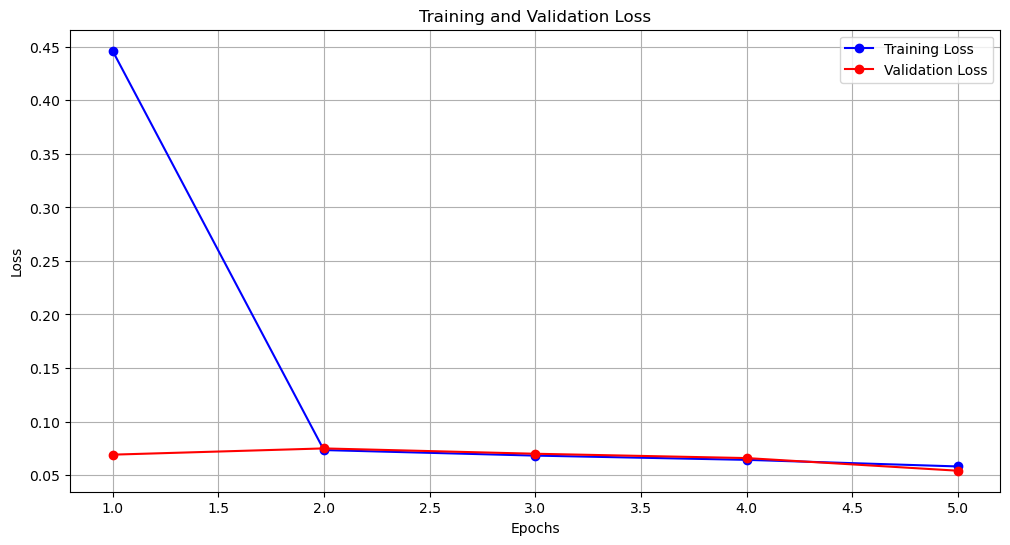

In [53]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)


In [158]:
predictions = model.predict(X_train)


7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step


In [156]:
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

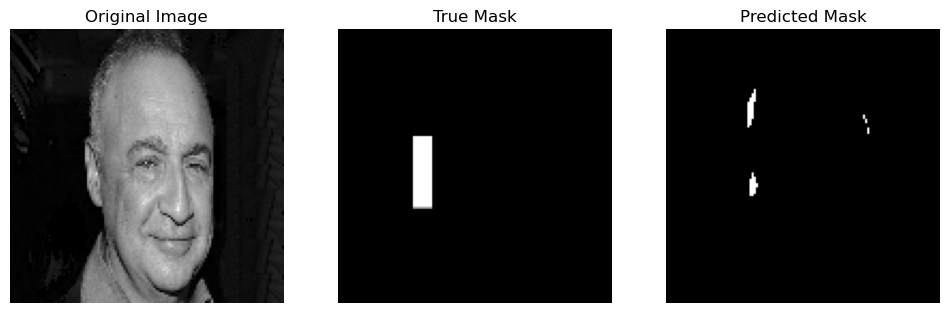

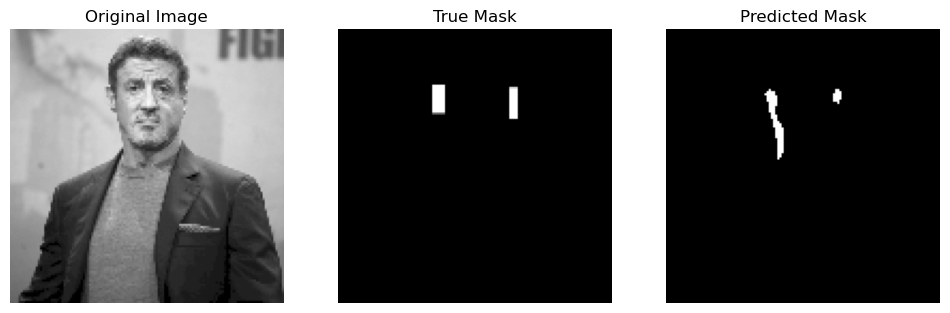

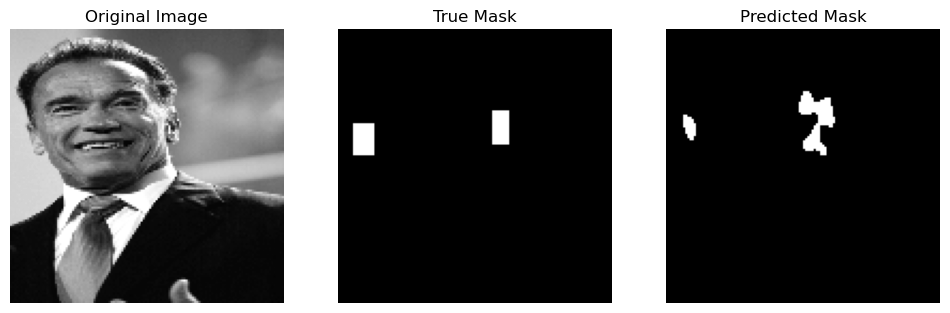

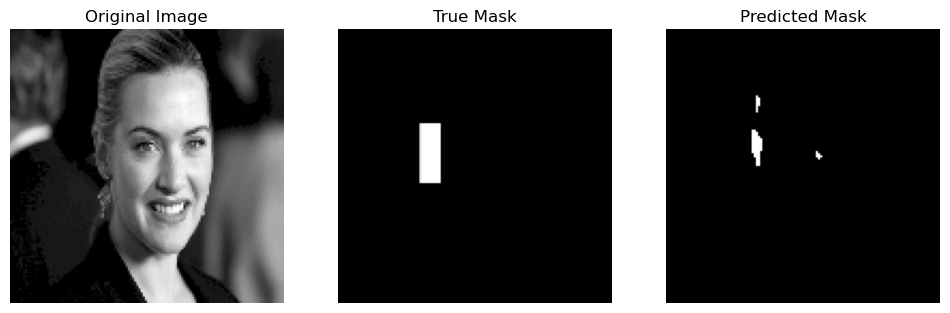

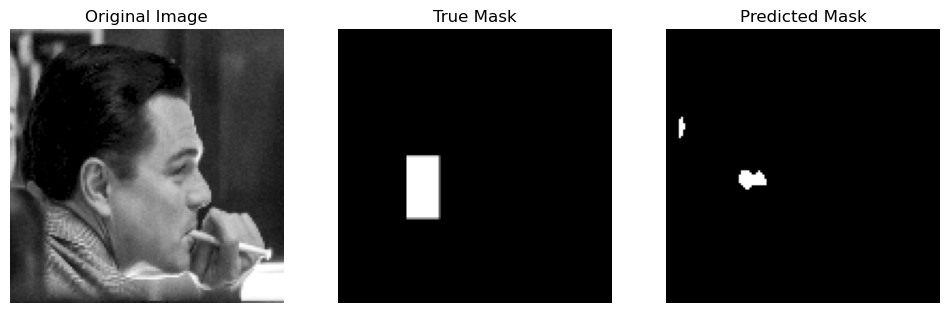

In [162]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(x_val, y_val, predictions, num_samples=5):
    for i in range(num_samples):

        # Get the i-th image, mask, and prediction
        img = x_val[i]
        true_mask = y_val[i]
        pred_mask = predictions[i]

        # Post-process the prediction
        pred_mask = np.squeeze(pred_mask)
        threshold = 0.15
        pred_mask_binary = (pred_mask > threshold).astype(np.uint8)

        # Plot original image, true mask, and predicted mask
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img.squeeze(), cmap='gray')  # Remove singleton dimensions
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(true_mask.squeeze(), cmap='gray')  # Remove singleton dimensions
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(pred_mask_binary, cmap='gray')
        plt.axis('off')

        plt.show()

# Example usage
visualize_predictions(X_train, Y_train, predictions, num_samples=5)


In [21]:
images,masks = load_images('test','testannot_rect')

Image Files: ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0

In [28]:
from tensorflow.keras.models import load_model

model = load_model('unet_model.h5')

In [30]:
predictions = model.predict(images)

8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step


In [31]:
def process_prediction(prediction, threshold=0.2):
    prediction = np.squeeze(prediction)  # Remove singleton dimensions
    return (prediction > threshold).astype(np.uint8)  # Convert to binary

In [34]:
predicted_masks = np.array([process_prediction(pred) for pred in predictions])

In [36]:
def pixel_accuracy(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return accuracy_score(y_true_flat, y_pred_flat)

In [38]:
y_test_binary = (masks > 0.5).astype(np.uint8) 

In [43]:
from sklearn.metrics import accuracy_score

In [45]:
accuracies = [pixel_accuracy(y_test_binary[i], predicted_masks[i]) for i in range(len(y_test_binary))]

In [47]:
overall_accuracy = np.mean(accuracies)
print(f"Overall Pixel-Wise Accuracy: {overall_accuracy * 100:.2f}%")

Overall Pixel-Wise Accuracy: 98.25%


In [49]:
test_loss, test_accuracy = model.evaluate(images,masks, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9835 - loss: 0.0521
Test Loss: 0.053989626467227936
Test Accuracy: 98.29%


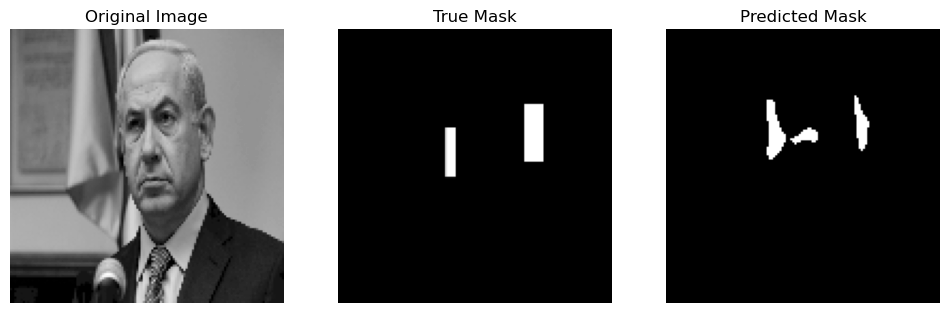

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize test images, true masks, and predicted masks
def visualize_test_predictions(x_test, y_test, predicted_masks, num_samples=5):
    for i in range(num_samples):
        if i==4:
            # Fetch the original image, true mask, and predicted mask
            img = x_test[i]
            true_mask = y_test[i]
            pred_mask = predicted_masks[i]
        
            # Threshold the predicted mask to convert it to binary (if required)
            pred_mask_binary = (pred_mask > 0).astype(np.uint8)  # Binary threshold at 0.5

            plt.figure(figsize=(12, 6))
        
            # Show the original image
            plt.subplot(1, 3, 1)
            plt.title('Original Image')
            plt.imshow(img.squeeze(), cmap='gray')
            plt.axis('off')
        
            # Show the true binary mask
            plt.subplot(1, 3, 2)
            plt.title('True Mask')
            plt.imshow(true_mask.squeeze(), cmap='gray')
            plt.axis('off')
        
            # Show the predicted binary mask
            plt.subplot(1, 3, 3)
            plt.title('Predicted Mask')
            plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
            plt.axis('off')
        
            # Display the plot
            plt.show()
        


# Visualize predictions for 5 random samples
visualize_test_predictions(images, masks, predicted_masks, num_samples=5)